

<br>


<h1><center> SFS </center></h1>


<br>
<br>

#### Signal Formation Simulation
The idea is to develop a lightweight and easy-to-use tool for the top-down how affects the performance of the next-generation dark matter detector.
The code is based on the Noble Element Simulation Technique (NEST).


<br>


#### This Notebook
This is the notebook that was used to actually conduct the study.
It is supposed to further serve as documentation of the ''sfs.py'' library. Feel free to copy the exemplary function calls below into your personal study project.


<br>


#### Contents


<br>


#### Credits
- NEST collaboration
- C. Hock


<br>
<br>



<br>


# Setup


<br>
<br>


- install NEST following their official documentation
- git clone the ''sfsv2'' repository
- edit the ''sfs.py'' file
- 


<br>
<br>



<br>


# Imports and Definitions


<br>
<br>


In [1]:

# imports <---- check which one of those are actually needed
import subprocess
import numpy as np
import matplotlib.pyplot as plt


# path definitions
abspath_sfs_repo = "/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/"
abspath_study = abspath_sfs_repo # you'll probably have different paths for 'abspath_sfs_repo' and 'abspath_study'
abspath_detectors = abspath_study +"detectors/"
abspath_spectra = abspath_study +"spectra/"
abspath_resources = abspath_study +"resources/"
abspath_list_plots = [abspath_study +"plots/", "/home/daniel/Desktop/arbeitsstuff/thesis/images/sfs/"]


# importing my personyl matplotlib style files
import matplotlib as mpl
plt.style.use("file:///home/daniel/Desktop/arbeitsstuff/monxe/software/miscfig/danielsmplstyle.mplstyle")


# importing the sfs library
import sys
sys.path.append(abspath_sfs_repo)
import sfs



<br>


# Signal Formation Simulation with NEST


<br>
<br>



#### Spectra and Detector Generation

In [2]:

#if [False,True][1]:

    

#### Executing NEST

In [3]:

if [False,True][0]:


    execNEST_ndarray = sfs.execNEST(
        spectrum_dict = {
#            "numEvts" : [10, 10, 10, 10],
            "numEvts" : 10,
            "type_interaction" : "ER",
#            "E_min[keV]" : [100, 100, 100, 100],
#            "E_max[keV]" : [100, 100, 100, 100],
            "E_min[keV]" : 100,
            "E_max[keV]" : 100,
            "field_drift[V/cm]" : "200",
        },
#        detector_dict = {},
        detector_dict = {
            "g1" : 1.9,
            "g1_gas" : 1.9,
        },
        detector_name = "rndm_new_detector",
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,
    )


    #print(len(execNEST_ndarray))


#### WIMP spectrum

gen_spectrum_plot: initializing with 'mode'='compute_dru''
gen_spectrum_plot: setting up canvas and axes


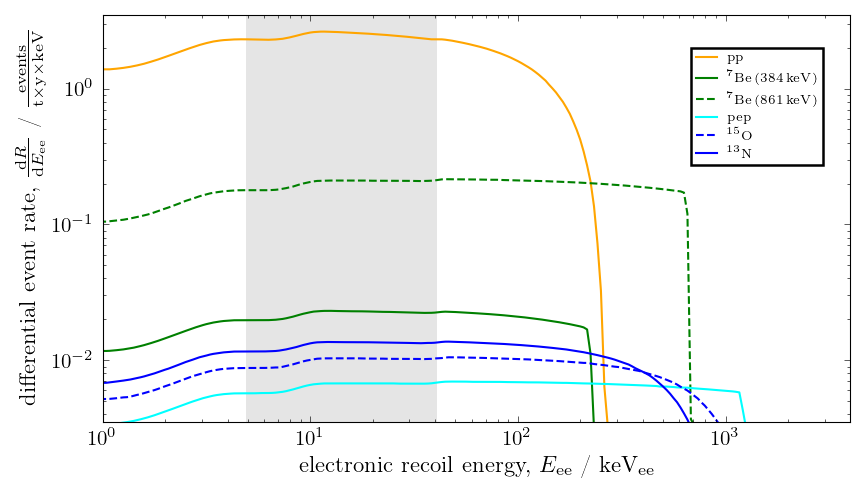

gen_spectrum_plot: initializing with 'mode'='compute_dru''
gen_spectrum_plot: setting up canvas and axes


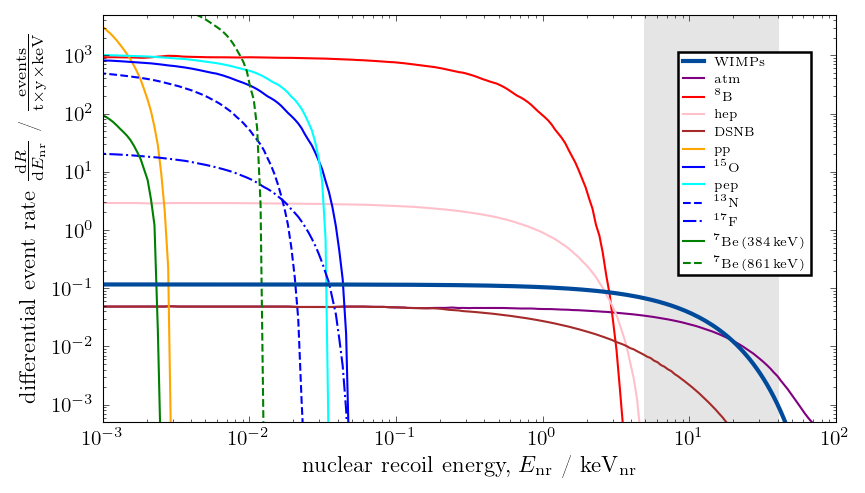

In [4]:

if [False,True][1]:


    sfs.gen_spectrum_plot(
        spectra_list = ["er_pp", "er_be7_384", "er_be7_861", "er_pep", "er_o15", "er_n13"],
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][2],
        plot_log_y_axis = True,
        plot_log_x_axis = True,
        plot_xlim = [1e+0,4e+3],
        plot_ylim = [3.5e-3,3.5e+0],
        plot_legend_bbox_to_anchor = [0.75, 0.55, 0.25, 0.45],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 6,
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "darwin_er_background_spectrum.png",
        flag_shade_wimp_eroi = sfs.wimp_eroi_kev_nr,
        flag_verbose = True,)


    sfs.gen_spectrum_plot(
        spectra_list = ["nr_wimps", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_o15", "nr_pep", "nr_n13", "nr_f17", "nr_be7_384", "nr_be7_861"],
        wimp_mass_gev = 100,
        wimp_nucleon_cross_section_cm2 = 1e-47,
        wimp_computation_method = ["default", "old", "cpp"][0],
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][1],
        plot_log_y_axis = True,
        plot_log_x_axis = True,
        plot_xlim = [1e-3,1e+2],
        plot_ylim = [5e-4,5e+3],
        plot_legend_bbox_to_anchor = [0.75, 0.27, 0.25, 0.73],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 6,
        flag_output_abspath_list = abspath_list_plots,
        flag_shade_wimp_eroi = sfs.wimp_eroi_kev_nr,
        flag_output_filename = "darwin_nr_background_spectrum.png",
        flag_verbose = True,)



<br>


# ER/NR Discrimination


<br>
<br>




<br>


# Maximum Likelihood Sensitivity Estimation


<br>
<br>

